In [1]:
# Python Notebook for PHYS 421 Assignment #6

import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from matplotlib import rc
import scipy as sp

# extra stuff to make the plots look nice:

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

params = {"text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["cmr10"],
          "font.size": 20
         }
plt.rcParams.update(params)
plt.rcParams['axes.formatter.use_mathtext'] = True

import os
os.environ["PATH"]
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin/'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

# Set tick parameters using rcParams
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.major.width'] = 0.7
plt.rcParams['xtick.minor.width'] = 0.7
plt.rcParams['ytick.major.width'] = 0.7
plt.rcParams['ytick.minor.width'] = 0.7

plt.rcParams['font.weight'] = 'bold'

from matplotlib.colors import PowerNorm


### 2. Weather in the Land of Oz

In [2]:
# we will first double check our answers for Question 2:

# transition matrix:
M = np.array([[0,0.5,0.5],[0.25,0.5,0.25],[0.25,0.25,0.5]])

# initial probability vector:
v = np.array([1,0,0])

In [3]:
# first what happens when we apply the transition matrix twice:

v_wed = np.dot(np.dot(v, M), M)

print(f"The probability of a nice day on Wednesday given a nice day on Monday is {v_wed[0]}")
print("Which matches what was found analytically!")

The probability of a nice day on Wednesday given a nice day on Monday is 0.25
Which matches what was found analytically!


In [4]:
# next we can find the steady state by applying the transition matrix an 
# arbitrary number of times:

N = 200

# mutable vector:
test_v = v

for i in range(N):
    test_v = np.dot(test_v, M)
    
print("The steady state probabilities are: " + str(test_v))
print("Which match what was found analytically!")

The steady state probabilities are: [0.2 0.4 0.4]
Which match what was found analytically!


### 3. Ising model in two dimensions

Use your favorite computer software (Mathematica, Matlab, Python etc) to simulate
the Ising model in two dimensions on a 50 × 50 square lattice. The Hamiltonian is

$$
H = −J \sum_{\langle ij \rangle} \sigma_i \sigma_j
$$

where $\sigma_i = \pm 1$, the sum is over all nearest-neighbor pairs, and periodic boundary
conditions are used for all states. 

Use importance sampling and the single-spin-flip
Metropolis algorithm to simulate the canonical ensemble at an inverse temperature $\beta$.

See my notes on Brightspace for a description of the algorithm. Use a larger lattice if
your computer is fast enough. 

In particular:
* Perform your Monte-Carlo runs at several different temperatures, and plot the average magnetization

$$
\bar{m} = \frac{1}{N} \overline{\sum_i \sigma_i}
$$
in equilibrium as a function of $\beta J$ (or of kT /J).

* Comment on the Monte-Carlo time required to reach the equilibrium. Does this time depend on your initial state?

* Do you see a signature of the phase transition? How does the transition temperature you find compare with the analytical answer $kT_c \approx 2.269J$ (the exact result for an infinite lattice is sinh(2J/kTc) = 1)?

* Include both your commented code and a separate human-readable description of what different parts of your code are doing.

The algorithm we will follow here is in the notes and goes as:

1. Start with an initial state (an arrangement of +1’s and −1’s on a lattice),

2. Flip one spin (arbitrarily chosen) in the current state, obtaining the new state,

3. Find $\Delta$E = Enew state − Eold state,
4. If $\Delta E \le 0$, accept the new state,
5. If $\Delta E \gt 0$, accept the new state with probability $e^{−\beta \Delta E}$ ,
6. Go back to step 2,
7. Repeat till equilibrium is established,
8. Measure your mean observables by averaging over time in equilibrium.


To perform these steps we need a number of quanities. We will only consider the interactions between the neighbouring spins for a given spin flip and so the change in energy is given for a particular spin flip as:

$$
\Delta E(a,b) = JS_{a+1,b} + JS_{a-1,b} +JS_{a,b+1} +JS_{a,b-1}
$$

Where a, b are the indices of the spin that has been flipped and S takes values of either +1 or -1. To account for the periodicity of the lattice we may make use of the modulo operator:

$$
\Delta E(a,b) = JS_{a+1 mod N,b} + JS_{a-1 mod N,b} +JS_{a,b+1 mod N} +JS_{a,b-1 mod N}
$$

The acceptance function in terms of this $\Delta E(a,b)$ becomes:

$$
A = 
\left\{
    \begin{array}{lr}
        \text{accept}, & \text{if }  \Delta E(a,b) \le 0\\
        \text{accept}, & \text{if }  \Delta E(a,b) > 0  \ \text{with} \ P(\Delta E) = e^{-\beta \Delta E(a,b)} \\
    \end{array}
\right\} 
$$

We also may find the mean magnetic moment of the configuration using the following:

$$
\bar{m} =\frac{1}{N} \overline{\sum_i \sigma_i}
$$

Of note is that this N is the total number of spins and not the size of the lattice. 

In [5]:
import random

In [6]:
# I will attempt to do this generally such that we can extend it to
# arbitrary inputs and compute additional quanitites:

# The first step is to generate a random grid of 
# +/- 1 spins on a 50 x 50 lattice: 

def make_lattice(N):
    '''
    Takes a lattice size NxN
    and returns a random matrix 
    of spins that take values 
    of either +1 or -1
    '''
    grid = np.zeros([N, N])
    for i in range(N):
        for j in range(N):
            grid[i,j] = random.choice((-1,1))
    return np.array(grid)

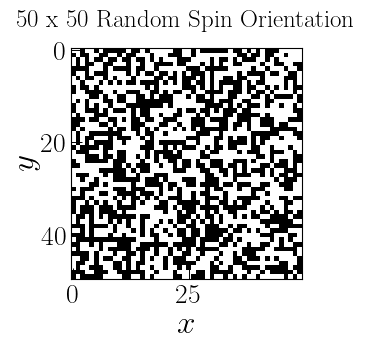

In [96]:
# lets plot this to see whats going on:
width=4;height=3;ff, ax1 = plt.subplots(1,1);ff.set_figwidth(width);ff.set_figheight(height);

# labels
ax1.set_title(r"50 x 50 Random Spin Orientation", pad = 15, fontsize=18)
ax1.set_xlabel(r"$x$",labelpad =1, fontsize=24)
ax1.set_ylabel(r"$y$",labelpad =1,fontsize=24)

ax1.imshow(make_lattice(50), cmap='bone')

plt.show()
    

In [149]:
# we now wish to implement the algorithm:

def algorithm(N, T, iters, J=1):
    '''
    Takes a grid size N,
    a T value, and the number
    of iterations and returns the final 
    equilibrium grid, 
    the average magnetization
    over time and potential 
    other quantities that might be 
    useful in analysis
    '''
    # we first generate the initial lattice:
    lattice = make_lattice(N)
    
    # initiates a magnetization array:
    avg_mag = np.zeros(iters)
    
    # loops through the lattice flipping a single
    # grid point using the acceptance function above:
    
    for i in range(iters):

        # randomly selects a spin at index a,b
        a_ind = np.random.randint(0,N)
        b_ind = np.random.randint(0,N)
        
        # gets the current spin at this position:
        
        curr_spin = lattice[a_ind, b_ind]
        
        # calculates the change in energy due to the spin flip:
        delta_E = J*curr_spin*(lattice[(a_ind-1)%N, b_ind]+ \
                              lattice[(a_ind+1)%N, b_ind]+ \
                              lattice[a_ind,(b_ind-1)%N]+ \
                              lattice[a_ind,(b_ind+1)%N])
        
        # checks the criteria of the acceptance function
        # and changes the lattice accordingly:
        
        if delta_E <= 0:
            lattice[a_ind,b_ind] *=-1
            
        elif delta_E > 0:
            probability = np.exp(-delta_E/T)

            accept = (np.random.rand() < probability)
            
            if accept == True:
                lattice[a_ind,b_ind] *=-1
            elif accept == False:
                pass
                    
        # computes the average magnetization of the configuration:

        avg_mag_i = (1/N**2) * np.sum(lattice)
        avg_mag[i] = avg_mag_i
    
    return lattice, avg_mag

In [270]:
# calculates the spin orientation for various kTs:
# the number of iterations has been played with to optimize plots:
# to keep run time down, not all of the curves have the same 
# iterations:
Ts = np.array([0.01, 0.1, 1.0, 2.0, 2.5, 10.0])

T_0_0_1 = algorithm(50, Ts[0], 1000000)
T_0_1   = algorithm(50, Ts[1], 1000000)
T_1     = algorithm(50, Ts[2], 1000000)
T_2     = algorithm(50, Ts[3], 1000000)
T_2_5   = algorithm(50, Ts[4], 1000000)
T_10    = algorithm(50, Ts[5], 1000000)

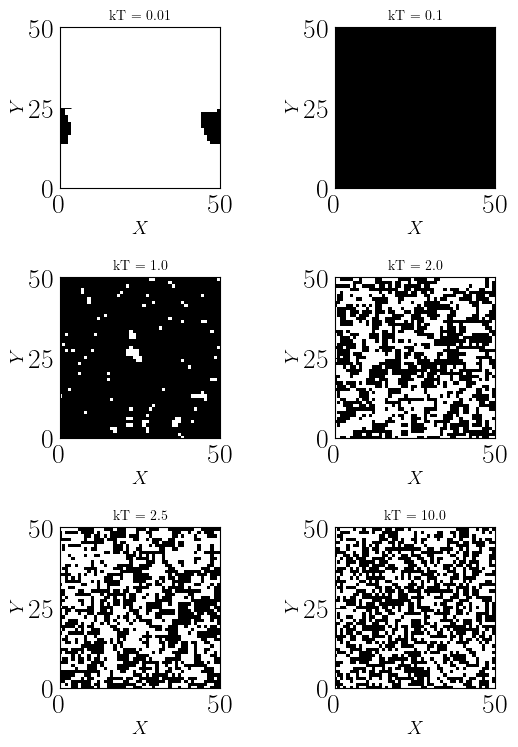

In [271]:
# initiates plotting parameters
width=6;height=8;ff, ax1 = plt.subplots(3,2);ff.set_figwidth(width);ff.set_figheight(height);ff.tight_layout(pad=1.8)

# labels
#ff.suptitle(r"Lattice Orientation for kT=0.01, 0.1, 1.0, 2.0, 2.5, 10 ", fontsize=18)
ax1[0,0].set_xlabel(r"$X$",labelpad =1.5, fontsize=14)
ax1[0,0].set_ylabel(r"$Y$",labelpad =1.5,fontsize=14)
ax1[1,0].set_xlabel(r"$X$",labelpad =1.5, fontsize=14)
ax1[1,0].set_ylabel(r"$Y$",labelpad =1.5,fontsize=14)
ax1[2,0].set_xlabel(r"$X$",labelpad =1.5, fontsize=14)
ax1[2,0].set_ylabel(r"$Y$",labelpad =1.5,fontsize=14)
ax1[0,1].set_xlabel(r"$X$",labelpad =1.5, fontsize=14)
ax1[0,1].set_ylabel(r"$Y$",labelpad =1.5,fontsize=14)
ax1[1,1].set_xlabel(r"$X$",labelpad =1.5, fontsize=14)
ax1[1,1].set_ylabel(r"$Y$",labelpad =1.5,fontsize=14)
ax1[2,1].set_xlabel(r"$X$",labelpad =1.5, fontsize=14)
ax1[2,1].set_ylabel(r"$Y$",labelpad =1.5,fontsize=14)

# actual plots:
ax1[0,0].imshow(T_0_0_1[0], cmap='bone')
ax1[0,1].imshow(T_0_1[0], cmap='bone')
ax1[1,0].imshow(T_1[0], cmap='bone')
ax1[1,1].imshow(T_2[0], cmap='bone')
ax1[2,0].imshow(T_2_5[0], cmap='bone')
ax1[2,1].imshow(T_10[0], cmap='bone')

ax1[0,0].set_title('kT = 0.01 ',fontsize=10)
ax1[0,1].set_title('kT = 0.1  ',fontsize=10)
ax1[1,0].set_title('kT = 1.0 ' ,fontsize=10)
ax1[1,1].set_title('kT = 2.0 ' ,fontsize=10)
ax1[2,0].set_title('kT = 2.5 ' ,fontsize=10)
ax1[2,1].set_title('kT = 10.0 ',fontsize=10)
ax1[0,0].set_xlim(0,50)
ax1[0,0].set_ylim(0,50)
ax1[1,0].set_xlim(0,50)
ax1[1,0].set_ylim(0,50)
ax1[2,0].set_xlim(0,50)
ax1[2,0].set_ylim(0,50)
ax1[0,1].set_xlim(0,50)
ax1[0,1].set_ylim(0,50)
ax1[1,1].set_xlim(0,50)
ax1[1,1].set_ylim(0,50)
ax1[2,1].set_xlim(0,50)
ax1[2,1].set_ylim(0,50)

plt.show()

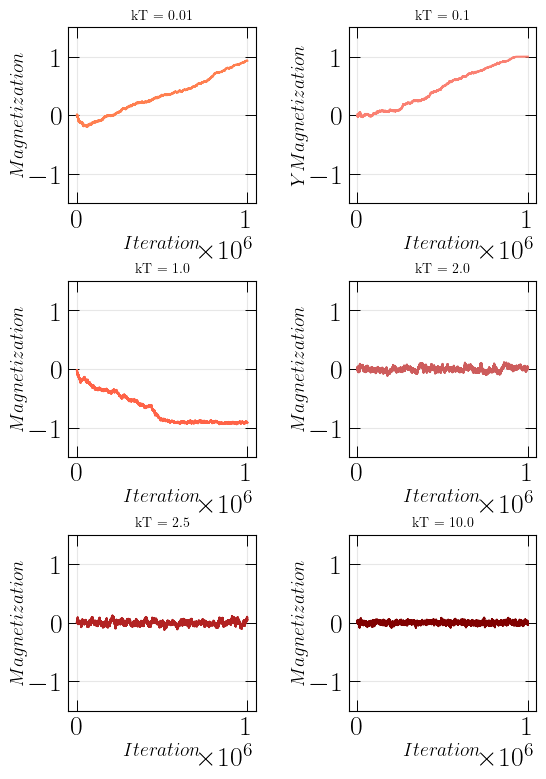

In [286]:
# initiates plotting parameters
width=6;height=8;ff, ax1 = plt.subplots(3,2);ff.set_figwidth(width);ff.set_figheight(height);ff.tight_layout(pad=1.4)

# labels
#ff.suptitle(r"Lattice Orientation for kT=0.01, 0.1, 1.0, 2.0, 2.5, 10 ", fontsize=18)
ax1[0,0].set_xlabel(r"$Iteration$",labelpad =1.5, fontsize=14)
ax1[0,0].set_ylabel(r"$Magnetization$",labelpad =1.5,fontsize=14)
ax1[1,0].set_xlabel(r"$Iteration$",labelpad =1.5, fontsize=14)
ax1[1,0].set_ylabel(r"$Magnetization$",labelpad =1.5,fontsize=14)
ax1[2,0].set_xlabel(r"$Iteration$",labelpad =1.5, fontsize=14)
ax1[2,0].set_ylabel(r"$Magnetization$",labelpad =1.5,fontsize=14)
ax1[0,1].set_xlabel(r"$Iteration$",labelpad =1.5, fontsize=14)
ax1[0,1].set_ylabel(r"$YMagnetization$",labelpad =1.5,fontsize=14)
ax1[1,1].set_xlabel(r"$Iteration$",labelpad =1.5, fontsize=14)
ax1[1,1].set_ylabel(r"$Magnetization$",labelpad =1.5,fontsize=14)
ax1[2,1].set_xlabel(r"$Iteration$",labelpad =1.5, fontsize=14)
ax1[2,1].set_ylabel(r"$Magnetization$",labelpad =1.5,fontsize=14)

# actual plots:
ax1[0,0].plot(np.linspace(0, len(T_0_0_1[1]), len(T_0_0_1[1])),T_0_0_1[1],c='coral')
ax1[0,1].plot(np.linspace(0, len(T_0_1[1]), len(T_0_1[1])),T_0_1[1],  c='salmon')
ax1[1,0].plot(np.linspace(0, len(T_1[1]), len(T_1[1])),T_1[1],    c='tomato')
ax1[1,1].plot(np.linspace(0, len(T_2[1]), len(T_2[1])),T_2[1],    c='indianred')
ax1[2,0].plot(np.linspace(0, len(T_2_5[1]), len(T_2_5[1])),T_2_5[1],  c='firebrick')
ax1[2,1].plot(np.linspace(0, len(T_10[1]), len(T_10[1])),T_10[1],   c='maroon')

ax1[0,0].set_title('kT = 0.01 ',fontsize=10)
ax1[0,1].set_title('kT = 0.1  ',fontsize=10)
ax1[1,0].set_title('kT = 1.0 ' ,fontsize=10)
ax1[1,1].set_title('kT = 2.0 ' ,fontsize=10)
ax1[2,0].set_title('kT = 2.5 ' ,fontsize=10)
ax1[2,1].set_title('kT = 10.0 ',fontsize=10)

ax1[0,0].xaxis.set_ticks_position('both') 
ax1[0,0].yaxis.set_ticks_position('both')
ax1[0,0].grid(True, alpha=0.3, zorder=10)
ax1[1,0].xaxis.set_ticks_position('both') 
ax1[1,0].yaxis.set_ticks_position('both')
ax1[1,0].grid(True, alpha=0.3, zorder=10)
ax1[2,0].xaxis.set_ticks_position('both') 
ax1[2,0].yaxis.set_ticks_position('both')
ax1[2,0].grid(True, alpha=0.3, zorder=10)
ax1[0,1].xaxis.set_ticks_position('both') 
ax1[0,1].yaxis.set_ticks_position('both')
ax1[0,1].grid(True, alpha=0.3, zorder=10)
ax1[1,1].xaxis.set_ticks_position('both') 
ax1[1,1].yaxis.set_ticks_position('both')
ax1[1,1].grid(True, alpha=0.3, zorder=10)
ax1[2,1].xaxis.set_ticks_position('both') 
ax1[2,1].yaxis.set_ticks_position('both')
ax1[2,1].grid(True, alpha=0.3, zorder=10)

ax1[0,0].set_ylim(-1.5, 1.5)
ax1[1,0].set_ylim(-1.5, 1.5)
ax1[2,0].set_ylim(-1.5, 1.5)
ax1[0,1].set_ylim(-1.5, 1.5)
ax1[1,1].set_ylim(-1.5, 1.5)
ax1[2,1].set_ylim(-1.5, 1.5)
plt.show()

As we can see from the above plot, there is a difference in the 
time it takes for a configuration to obtain equilibrium. It appears that lower temperature simulations take longer to equilibrate. This makes some sense as it is more likely to reject a change in the orientation at lower temperatures. Spoiler alert: For temperatures less than 2, we achieve equilibrium at large iterations. It seems to occur at ~500000 for kT=1.0, < 1000000 for kT = 0.1, and > 1000000 for kT = 0.01. Around 2.0, we see considerable noise and not a lot of equilibrating. At values of temperature above kT=2.0, we find a convergence to 0.0 with oscillatory behaviour amplitudes that are somehow proportional to the inverse of kT.

In [294]:
# we can now investigate the phase transition by calculating
# the final magnetization for a bunch of temperatures:

# the problem here is the run time needed for convergence is very high. 
# to do this properly, we would need to run quite a few different 
# temperatures to high iterations. Will start first with high # of T and 
# a medium sized iteration value:

# array of different times, will center it around 2.0 or so
# since thats where were expecting a transition. The question is posed 
# such that we wish to confirm or deny the presence of it there so 
# we know which regions to look in.

#temps = np.array([0.001, 0.005, 0.01, 0.03, 0.05, 0.07, 0.1, 0.3, 0.5, \
#                  0.7, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6 ,1.7, 1.8, \
#                  1.9, 2.0,2.05, 2.1, 2.15, 2.20, 2.25, 2.3, 2.235, 2.4, \
#                  2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.5, 4.0, 5, 7, 9, 10, 15,\
#                  20, 25])

temps = np.linspace(0.0001, 4, 200)

# array of final magnetization values:
mag_fin = np.zeros(len(temps))

for i in range(len(temps)):
    mag_fin[i] = algorithm(50, temps[i], 500000)[1][-1]



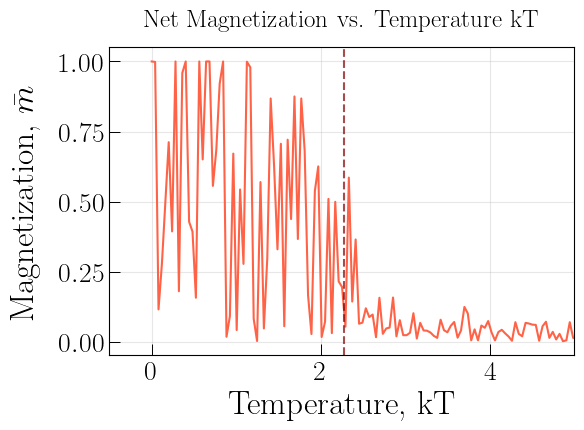

In [314]:
# lets plot this to see whats going on:
width=6;height=4;ff, ax1 = plt.subplots(1,1);ff.set_figwidth(width);ff.set_figheight(height);

# labels
ax1.set_title(r"Net Magnetization vs. Temperature kT", pad = 15, fontsize=18)
ax1.set_xlabel(r"Temperature, kT",labelpad =4, fontsize=24)
ax1.set_ylabel(r"Magnetization, $\bar{m}$",labelpad =14,fontsize=24)

# we may take the absolute value to turn any negative results 
# positive to get a better result curve.

ax1.plot(temps, np.abs(mag_fin), c='tomato')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-0.5, 5)
ax1.set_xlim(-0.5, 5)
ax1.axvline(x=2.269, linestyle='--', c='maroon', alpha=0.7)

plt.show()

The above plot demonstrates a number of things. The first is that there is clearly a phase transition from non-zero magnetization to approximately zero magnetization. This transition straddles the line we get from analytic theory, With the magnetization decreasing considerably at this point for the most part. We also see that even with a large number of iterations, we have significant noise present on either side of the phase transition. This is in part due to the random nature of the way we are constructing the states. The other is that adequate convergence takes a considerable number of iterations. For low kT, this number is on the order of $10^6$ or $10^7$ which is not feasible here. Upping this value would likely result in better convergence. 